In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def getClearLogs(experiment_logs):
  experiment_data = []
  for log in experiment_logs:
    cleared_log = log.split("[JavaFX Application Thread] ")
    cleared_log.pop(0)
    if (len(cleared_log) >= 1) and ("Experiment" in cleared_log[0]):
      experiment_data.append(cleared_log)
  return experiment_data

def getOrderDistributionStrategy(strategy_class_name):
  if strategy_class_name == "class mat.agent.reactive.strategy.ECNPStrategy":
    return "ECNP"
  elif strategy_class_name == "class mat.agent.reactive.strategy.CNPStrategy":
    return "CNP"
  else: 
    return "NoCNP"

def findPercentageSetting(num_of_agents, num_of_idling_zone):
  percentage_settings = [25, 50, 100, 150, 200]
  real_value = math.ceil((num_of_idling_zone/num_of_agents)*100)
  return min(percentage_settings, key=lambda x:abs(x-real_value))

In [ ]:
def getExperimentInfo(experiment_logs):
  experiment_info = {
      "Size X": [],
      "Size Y": [],
      "Num of idling zones": [],
      "Num of agents": [],
      "Idling zone percentage": [],
      "Idling zone dist": [],
      "Order dist strategy": [],
      "Completed orders": [],
      "Collisions": []
  }

  for log in experiment_logs:
    splitted_logs = log[0].split(" - ")
    if len(splitted_logs) >= 1 and splitted_logs[1] == "Grid":
      experiment_info_logs = splitted_logs[2].split(",")
      size_x = int(experiment_info_logs[0].split(":")[1])
      size_y = int(experiment_info_logs[1].split(":")[1])
      num_of_idling_zone = int(experiment_info_logs[2].split(":")[1])
      num_of_agents = int(experiment_info_logs[3].split(":")[1])
      idling_zone_percentage = findPercentageSetting(num_of_agents, num_of_idling_zone)
      order_dist_strategy = getOrderDistributionStrategy(experiment_info_logs[5].split(":")[1])
      experiment_info["Size X"].append(size_x)
      experiment_info["Size Y"].append(size_y)
      experiment_info["Num of idling zones"].append(num_of_idling_zone)
      experiment_info["Num of agents"].append(num_of_agents)
      experiment_info["Idling zone percentage"].append(idling_zone_percentage)
      experiment_info["Idling zone dist"].append(experiment_info_logs[4].split(":")[1])
      experiment_info["Order dist strategy"].append(order_dist_strategy)
    elif len(splitted_logs) >= 1 and "Collisions" in splitted_logs[1]:
      collision_info = splitted_logs[1]
      experiment_info["Collisions"].append(int(collision_info.split(":")[1].strip()))
    elif len(splitted_logs) >= 1 and splitted_logs[1] == "Result":
      result_info_log = splitted_logs[2].split(",")
      experiment_info["Completed orders"].append(int(result_info_log[0].split(":")[1]))
  return experiment_info

def getExperimentByType(size_x, idling_zone_percentage):
  title = "Experiment with grid size " + str(size_x) + "x" + str(size_x) + " and idling zone percentage of " + str(idling_zone_percentage) 
  return df.loc[(df['Size X'] == size_x) & ((df['Idling zone percentage'] == idling_zone_percentage) | (df['Idling zone percentage'] == idling_zone_percentage-1))], title

def getOrderDistributionExperimentResults(df):
  cnp = df.loc[df['Order dist strategy'] == "CNP"]
  ecnp = df.loc[df['Order dist strategy'] == "ECNP"]
  no_cnp = df.loc[df['Order dist strategy'] == "NoCNP"]
  return cnp, ecnp, no_cnp

def getIdlingZoneDistExperimentResult(df):
  random = df.loc[df['Idling zone dist'] == "RANDOM"]
  nearest = df.loc[df['Idling zone dist'] == "NEAREST_BORDER"]
  return random, nearest

def getMaxIdlingZonePoint(df, distribution, size_x):
  if size_x == 41:
    if distribution == "Distributed Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= int(40.5 * 3.81))]
    elif distribution == "Nearest Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= int(70.25 * 3.81))]
    elif distribution == "Random Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= int(71.28 * 3.81))]
  elif size_x == 21:
    if distribution == "Distributed Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= 39)]
    elif distribution == "Nearest Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= 67)]
    elif distribution == "Random Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= 69)]
  return maxIdlingZonePointData.iloc[0]

def plotExperiment(size_x, idling_zone_percentage):
  experiment_df, title = getExperimentByType(size_x, idling_zone_percentage)
  random, nearest = getIdlingZoneDistExperimentResult(experiment_df)
  random_cnp, random_ecnp, random_no_cnp = getOrderDistributionExperimentResults(random)
  nearest_cnp, nearest_ecnp, nearest_no_cnp = getOrderDistributionExperimentResults(nearest)
  plt.plot(random_cnp["Num of agents"], random_cnp["Completed orders"], color="blue", label="Random Dist. with CNP", linestyle="--",  marker="o", )
  plt.plot(random_ecnp["Num of agents"], random_ecnp["Completed orders"], color="green", label="Random Dist. with eCNP", linestyle="--",  marker="o", )
  plt.plot(random_no_cnp["Num of agents"], random_no_cnp["Completed orders"], color="yellow", label="Random Distribution", linestyle="--",  marker="o", )
  plt.plot(nearest_cnp["Num of agents"], nearest_cnp["Completed orders"], color="orange", label="Nearest Border Dist. with CNP", linestyle="--",  marker="o", )
  plt.plot(nearest_ecnp["Num of agents"], nearest_ecnp["Completed orders"], color="red", label="Nearest Border Dist. with eCNP", linestyle="--",  marker="o", )
  plt.plot(nearest_no_cnp["Num of agents"], nearest_no_cnp["Completed orders"], color="purple", label="Nearest Border Distribution", linestyle="--",  marker="o", )

  plt.tight_layout()
  lower_limit = roundToThousand(experiment_df["Completed orders"].min(), "lower")
  upper_limit = roundToThousand(experiment_df["Completed orders"].max(), "upper")  
  plt.yticks(np.arange(lower_limit, upper_limit, 1000))
  plt.legend(bbox_to_anchor =(0.5,-0.55), loc='lower center')
  plt.xlabel("Number of Agents")
  plt.ylabel("Number of Completed Orders")
  plt.title(title)
  plt.show()

def roundToThousand(realValue, direction):
  result = int(realValue / 1000)
  if direction == "lower":
    if result >= 1:
      return result * 1000
    else:
      return 0
  elif direction == "upper":
    return (result + 1) * 1000

def plotCollisionComparisonForExperiment(size_x, idling_zone_percentage):
  experiment_df, title = getExperimentByType(size_x, idling_zone_percentage)
  random, nearest = getIdlingZoneDistExperimentResult(experiment_df)
  random_cnp, random_ecnp, random_no_cnp = getOrderDistributionExperimentResults(random)
  nearest_cnp, nearest_ecnp, nearest_no_cnp = getOrderDistributionExperimentResults(nearest)

  inspectCollisionsOnPlot(random_cnp, "Random CNP", size_x, idling_zone_percentage)
  inspectCollisionsOnPlot(random_no_cnp, "Random", size_x, idling_zone_percentage)
  inspectCollisionsOnPlot(nearest_cnp, "Nearest CNP", size_x, idling_zone_percentage)
  inspectCollisionsOnPlot(nearest_no_cnp, "Nearest", size_x, idling_zone_percentage)
  inspectCollisionsOnPlot(random_ecnp, "Random eCNP", size_x, idling_zone_percentage)
  inspectCollisionsOnPlot(nearest_ecnp, "Nearest eCNP", size_x, idling_zone_percentage)

def inspectCollisionsOnPlot(df, title, size_x, idling_zone_percentage):
  fig, (ax1, ax2) = plt.subplots(2)
  fig.suptitle("Comparison of " + title + " and Collisions Occured" + "(" + str(size_x) + "x" + str(size_x) + " - " + str(idling_zone_percentage) + "%)", y=1.05)
  lower_limit = roundToThousand(df["Completed orders"].min(), "lower")
  upper_limit = roundToThousand(df["Completed orders"].max(), "upper")  
  ax1.plot(df["Num of agents"], df["Completed orders"], color="blue", label="Random Dist. with CNP", linestyle="--",  marker="o",)
  ax1.set_yticks(np.arange(lower_limit, upper_limit, 2000))
  ax2.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
  ax2.plot(df["Num of agents"], df["Collisions"], color="blue", label="Random Dist. with CNP", linestyle="--",  marker="o",)
  fig.tight_layout(pad=0.8)

def compareCollisonsTogether(size_x, idling_zone_percentage):
  experiment_df, title = getExperimentByType(size_x, idling_zone_percentage)
  random, nearest = getIdlingZoneDistExperimentResult(experiment_df)
  random_cnp, random_ecnp, random_no_cnp = getOrderDistributionExperimentResults(random)
  nearest_cnp, nearest_ecnp, nearest_no_cnp = getOrderDistributionExperimentResults(nearest)

  plt.plot(random_cnp["Num of agents"], random_cnp["Collisions"], color="blue", label="Random Dist. with CNP", linestyle="--",  marker="o", )
  plt.plot(random_ecnp["Num of agents"], random_ecnp["Collisions"], color="green", label="Random Dist. with eCNP", linestyle="--",  marker="o", )
  plt.plot(random_no_cnp["Num of agents"], random_no_cnp["Collisions"], color="yellow", label="Random Distribution", linestyle="--",  marker="o", )
  plt.title("Collison comparison on Random Dist." + "(" + str(size_x) + "x" + str(size_x) + " - " + str(idling_zone_percentage) + "%)", pad=15)
  plt.xlabel("Number of Agents")
  plt.ylabel("Number of Collisions")
  plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
  plt.legend(loc='upper right')
  plt.show()

  plt.plot(nearest_cnp["Num of agents"], nearest_cnp["Completed orders"], color="orange", label="Nearest Border Dist. with CNP", linestyle="--",  marker="o", )
  plt.plot(nearest_ecnp["Num of agents"], nearest_ecnp["Completed orders"], color="red", label="Nearest Border Dist. with eCNP", linestyle="--",  marker="o", )
  plt.plot(nearest_no_cnp["Num of agents"], nearest_no_cnp["Completed orders"], color="purple", label="Nearest Border Distribution", linestyle="--",  marker="o", )
  plt.title("Collison comparison on Nearest Border Dist." + "(" + str(size_x) + "x" + str(size_x) + " - " + str(idling_zone_percentage) + "%)", pad=15)
  plt.legend(loc='upper right')
  plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
  plt.xlabel("Number of Agents")
  plt.ylabel("Number of Collisions")
  plt.show()

In [ ]:
f = open("logs.log", "r")
experiment_logs = f.read().split("\n")
cleared_logs = getClearLogs(experiment_logs)
experiment_info = getExperimentInfo(cleared_logs)
df = pd.DataFrame(experiment_info)
df = df.sort_values(by='Num of agents', ignore_index=True)

In [ ]:
df

,Size X,Size Y,Num of idling zones,Num of agents,Idling zone percentage,Idling zone dist,Order dist strategy,Completed orders,Collisions
0,21,21,5,20,25,RANDOM,NoCNP,934,4545
1,21,21,5,20,25,RANDOM,CNP,1317,5124
2,21,21,5,20,25,RANDOM,ECNP,1316,5087
3,21,21,5,20,25,NEAREST_BORDER,NoCNP,1104,6039
4,21,21,5,20,25,NEAREST_BORDER,CNP,1260,5612
5,21,21,5,20,25,NEAREST_BORDER,ECNP,1271,5448
6,21,21,12,50,25,RANDOM,NoCNP,2152,34425
7,21,21,12,50,25,RANDOM,CNP,3163,33726
8,21,21,12,50,25,RANDOM,ECNP,3240,31834
9,21,21,12,50,25,NEAREST_BORDER,NoCNP,2175,36396


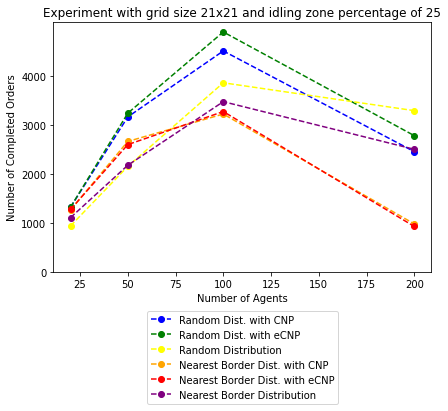

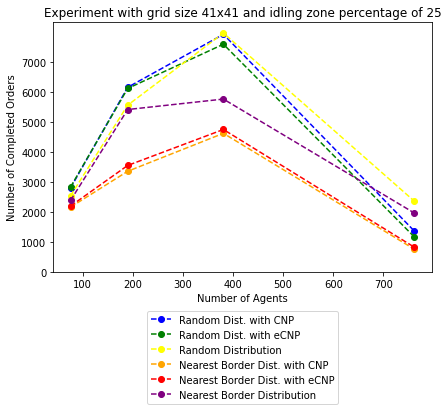

In [ ]:
plotExperiment(21, 25)
#plotExperiment(21, 50)
plotExperiment(41, 25)
#plotExperiment(41, 50)

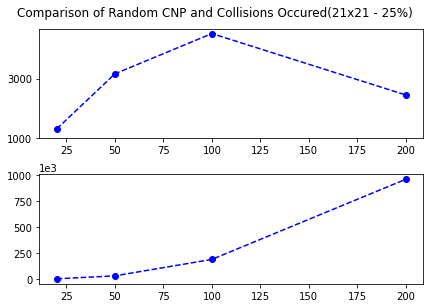

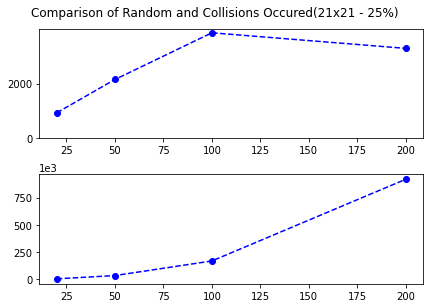

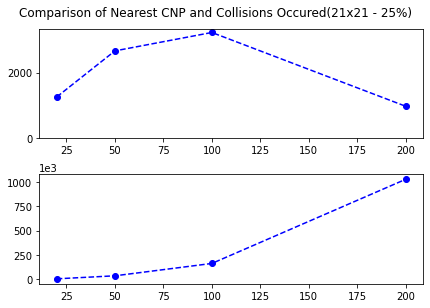

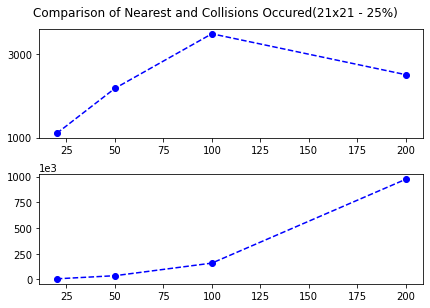

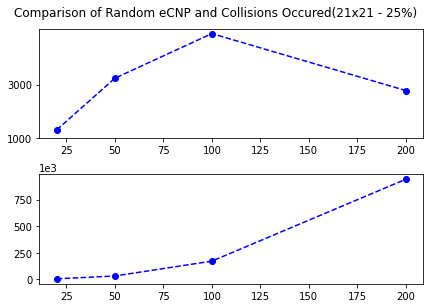

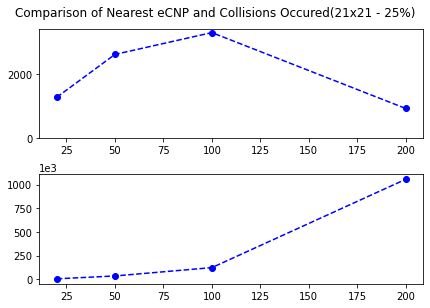

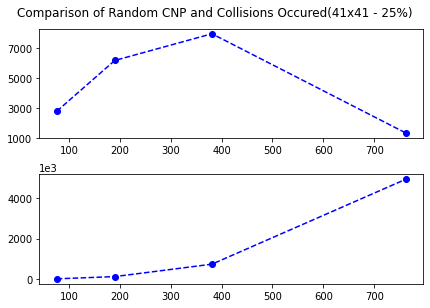

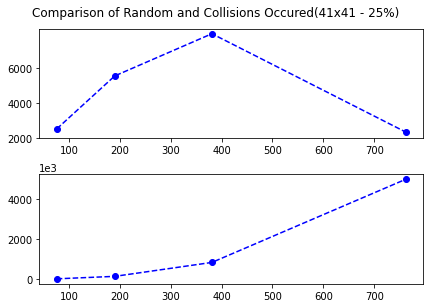

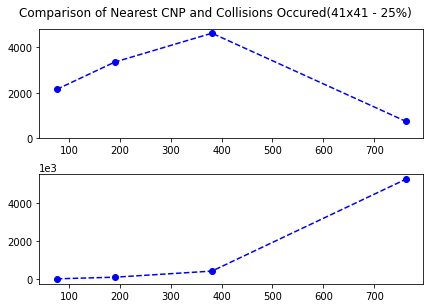

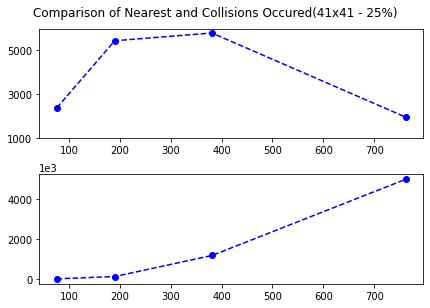

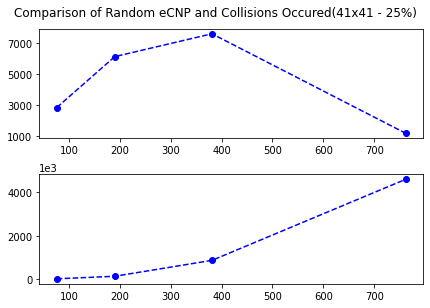

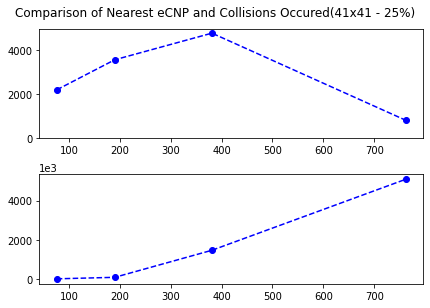

In [ ]:
plotCollisionComparisonForExperiment(21, 25)
#plotCollisionComparisonForExperiment(21, 50)
plotCollisionComparisonForExperiment(41, 25)
#plotCollisionComparisonForExperiment(41, 50)

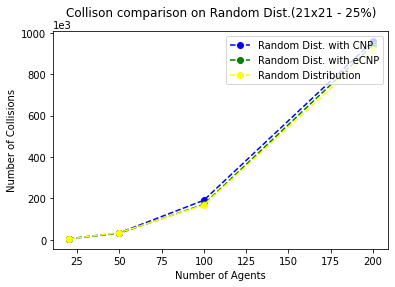

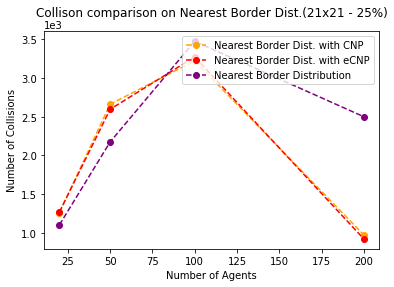

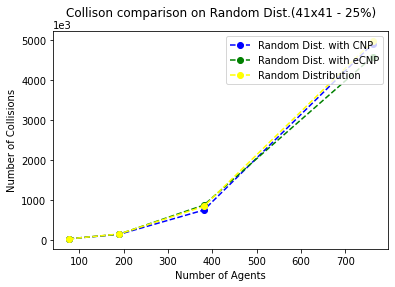

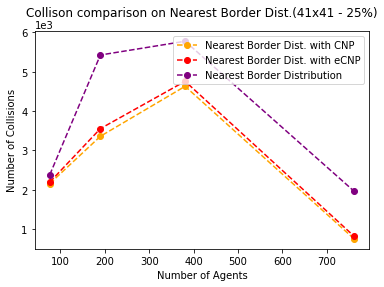

In [ ]:
compareCollisonsTogether(21, 25)
#compareCollisonsTogether(21, 50)
compareCollisonsTogether(41, 25)
#compareCollisonsTogether(41, 50)